# Understanding adjoints

Writing up my PhD is a pain mainly because of the detailed explanations that need to be provided. A technique I used throughout my project is to solve parameter optimization problems using the adjoint method. I learned the technique and used it, but never really _got_ it until reading an amazing paper. This post represents my notes and Julia implementation of the work detailed in https://math.mit.edu/~stevenj/18.336/adjoint.pdf by Steven G. Johnson which is by far the best description I have read on Adjoint methods. I am really grateful that I typed up these notes some time ago which makes my writing life easier... I hope they help someone to implement similar problems in Julia.

## Problem

This work implements the solution to the optimization problem for the Schrödinger eigenequation described in https://math.mit.edu/~stevenj/18.336/adjoint.pdf by Steven G. Johnson.

##  Boilerplate

Let's setup the Julia environment. Here I will use the [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) to solve the optimization problem and [IterativeSolvers.jl](https://github.com/JuliaMath/IterativeSolvers.jl) which provides the conjugate gradient method to solve the matrix equations.

In [1]:
using Pkg; Pkg.activate(".")

Activating environment at `~/git/Personal_Website/content/post/2020-06-14-adjoints/Project.toml`


In [2]:
using Optim, Plots, LineSearches, SparseArrays, LinearAlgebra, IterativeSolvers

## The Adjoint Method

I recommend you read Steven G. Johnson's [paper](https://math.mit.edu/~stevenj/18.336/adjoint.pdf ). The descriptions here are taken from that paper and summarized.

Given a set of equations M parametrized by a parameter P we optimize a function $g(x, p)$ on some space $x$. For optimizations we need the gradient $\frac{dg}{dp}$. The adjoint method rewrites the equation such that the we get a constant cost, it does not depend on the size of $P$ which is great if the dimension of the parameter space is large.

The change in the equation is shown next. Given $Ax=b$ with $A$ and $b$ parametrized by $P$:

$$
\begin{equation}
\frac{dg}{dp} = g_p + g_x x_p
\end{equation}
$$

Where $x$ is $MxM$ with $g_p$ being a Jacobian of size $1xP$, $g_x$ being a Jacobian on size $1xM$, $x_p$ of size $MxP$. The difficulty comes from plugging in $x_p$.

To get $x_p$ we differentiate $Ax=b$ by $p_i$ for each parameter to get:

$$
\begin{equation}
x_{pi} = A^{-1} (b_{pi} - A_{pi}x)
\end{equation}
$$

Plugging Equation 2 in Equation 1 we get:

$$
\begin{equation}
g_x x_p = g_x A^{-1} (b_p - A_p x) = [g_x A^{-1}] (b_p - A_p x)
\end {equation}
$$

With the terms $g_x A^{-1}$ of size $1xM$ and $b_p - A_p x$ of size $MxP$. The difficulty being is that the computational cost is $\mathcal{O}(M^2P)$.

To make the problem easier we can rearrange the equation. If we multiply by $\lambda^T = g_x A^{-1}$ and from Equation 1 and Equation 2 we get:

$$
\begin{equation}
\frac{dg}{dp} = g_p - \lambda^T (A_p x - b_p)
\end{equation}
$$

Where the multiplication now gives a tight bound $\Theta(MP)$.

## Eigenequation

The equation for the problem in the paper is an eigenequation so we need to also follow the section which derives this case. Equations of this type are given by:

$$
\begin{equation}
Ax = \alpha x
\end{equation}
$$

In block form we get:

$$
\begin{equation}
\hat{x} = \begin{bmatrix} x \\ \alpha \end{bmatrix}
\end{equation}
$$

And for $f = Ax - \alpha x$:

$$
\begin{equation}
\hat{f} = \begin{bmatrix} f \\ x^T x - 1 \end{bmatrix}
\end{equation}
$$

Using the same substitution for $\lambda$ we get:

$$
\begin{equation}
\hat{\lambda} = \begin{bmatrix} \lambda \\ \beta \end{bmatrix}
\end{equation}
$$

Putting this together:

$$
\begin{equation}
(A - \alpha) \lambda = g_x^T - 2\beta x
\end{equation}
$$

$$
\begin{equation}
-x^T \lambda = g_a
\end{equation}
$$

## Schrödinger eigenequation

The Schrödinger eigenequation is given by:

$$
\begin{equation}
\left(-\frac{d^2}{dx^2} + V(x)\right) \psi(x) = E\psi(x)
\end{equation}
$$

With periodic boundary conditions $\psi(x+2) = \psi(x)$ over a domain $x \in [-1, 1]$.

In direct solving we are given $V(x)$ and solve for $\psi$ and $E$, in parameter optimization (inverse) we are looking for $V(x)$ that minimizes some cost. In this case the cost is:

$$
\begin{equation}
g = \int_{-1}^{1} |\psi(x) - \psi_0 (x)|^2 dx
\end{equation}
$$

To solve the optimization problem we will:
- use finite difference method with central differencing to discretise the domain
- normalize $\psi$ to $\psi \psi^T = 1$
- project to $P = 1 - \psi \psi^T$
- solve the adjoint $\frac{dg}{dV} = \lambda \psi$
- solve $Ax = b$ for the smallest eigenvalue using Arnoldi iterations
- optimize $g(\psi, V) = (\psi - \psi_0)^T (\psi - \psi_0) \Delta x$ using the Conjugate Gradient method
- update the prediction $V(x)$ using the least-squares error against precalculated target data

In other cases the precalculated target data can come from experimental measurements, recorded data etc.

## Implementation

We setup the domain and the finite difference discretisation.

In [3]:
const m = 0.02
const x = [i for i in -1:m:1]
const N = length(x)
const dx = x[2] - x[1]

0.020000000000000018

We pick a function to generate the target data. This will later be used to compute the cost function and in inverse problems this is not known i.e. we are trying to backcalculate it. In my case such data comes from physical tests using thermocouples (very different than the example here but it can be solved with the same approach).

In [4]:
# Target solution, normalize and pick sign.
Ψ0 = 1.0 .+ sin.(π .* x .+ cos.(3 * π .* x))
Ψ0 = Ψ0 / sqrt(transpose(Ψ0) * Ψ0)
if(sum(Ψ0) < 0)
    Ψ0 = -Ψ0
end

In real problems we might be able to set prior knowledge about the problem but here we are just going to kick-start from an initial guess at $0$.

In [5]:
const V0 = [0.0 for i in -1:m:1];

Discretise the space using center-difference scheme and set the periodic boundary conditions.

In [6]:
Mesh = spdiagm(-1 => [1.0 for i in 1:N-1],
               0 => [2.0 for i in 1:N],
               1 => [1.0 for i in 1:N-1])

# Periodic boundary conditions.
Mesh[1, N] = 1.0
Mesh[N, 1] = 1.0

# Build mesh.
Mesh = -Mesh / dx^2;

Next we need to setup the optimization problem. For this we need to pass the parameters which we setup above and create a data structure to store the current calculation state.

In [7]:
# Build constants.
const p = [N, dx, Ψ0, Mesh]

mutable struct Schrodinger{T1, T2, T3}
    A::T1
    E::T2
    Ψ::T3
end

schr = Schrodinger(Mesh, 0.0, zeros(N));

The finite difference disretisation with an initial guess allows us to solve $Ax=b$ using Arnoldi iterations (Conjugate gradient) and computing the cost function as the least squares error between the generated target data and predictions form the the current solution state.

In [8]:
function schrodinger_fd(V, schr, p)
    N, _, Ψ0, Mesh = p

    A = Mesh + Diagonal(V)

    # Smallest values.
    E = eigvals(Matrix(A))[1]
    Ψ = eigvecs(Matrix(A))[:, 1]

    # Pick sign.
    if(sum(Ψ) < 0)
        Ψ = -Ψ
    end

    schr.A = A
    schr.E = E
    schr.Ψ = Ψ

    # Least-squares error.
    err = 0.0
    for i in 1:N
        err += (Ψ[i] - Ψ0[i])^2
    end

    return err
end

schrodinger_fd (generic function with 1 method)

Finally, we add the derived equations for the adjoint and pass the solution state to calculate the gradient. The adjoint equations are solved with the Conjugate gradient method.

In [9]:
function schrodinger_fd_adj(gp, V, schr, p)
    N, dx, Ψ0, _ = p

    A = schr.A
    E = schr.E
    Ψ = schr.Ψ

    gΨ = Ψ - Ψ0
    g = transpose(gΨ) * gΨ * dx
    gΨ = gΨ * 2 * dx

    P(Ψx) = Ψx - Ψ * (transpose(Ψ) * Ψx)
    λ = cg(A - Diagonal([E for i in 1:N]), P(gΨ))
    λ = P(λ)

    copyto!(gp, -real(conj(λ) .* Ψ))
end

schrodinger_fd_adj (generic function with 1 method)

We can now fill in the initial state with the guess for $V_0$.

In [10]:
schrodinger_fd(V0, schr, p)

0.36358289201172456

After the initial state we can pass with to [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) and optimize using the Conjugate gradient method and the [Nocedal and Wright line search](https://github.com/JuliaNLSolvers/LineSearches.jl).

In [11]:
res= optimize(V0 -> schrodinger_fd(V0, schr, p),
              (gp, V) -> schrodinger_fd_adj(gp, V, schr, p),
              V0,
              ConjugateGradient(;alphaguess = LineSearches.InitialStatic(),
                                linesearch = LineSearches.StrongWolfe()),
              Optim.Options(iterations = 1500))

show(res)
V = Optim.minimizer(res)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-6.97e+01, -6.31e+01, -5.21e+01,  ...]
    Minimum:   1.073967e-02

 * Found with
    Algorithm:     Conjugate Gradient
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.25e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.76e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.17e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.81e-04 ≰ 0.0e+00
    |g(x)|                 = 2.50e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   205  (vs limit Inf)
    Iterations:    1500
    f(x) calls:    25492
    ∇f(x) calls:   25492


101-element Array{Float64,1}:
 -69.7179927132526  
 -63.069608186066425
 -52.087451574006884
 -37.36573473180763 
 -20.180400235224578
  -2.229225733813316
  14.749615511053337
  29.331853859440123
  40.62554608422707 
  48.3225249611126  
  52.61571536510694 
  54.042947983512384
  53.31503924672539 
   ⋮                
  17.178647984621353
   8.021381994966156
  -2.573762022324184
 -14.023136038593602
 -25.664072903254834
 -36.846554029251884
 -47.03051365926664 
 -55.83742898698404 
 -63.019981543247575
 -68.35860212436283 
 -71.54666184631233 
 -72.15224515470479 

After the convergence criteria are met we can get the final state.

In [12]:
# Calculate the Ψ for the optimized V.
schrodinger_fd(V, schr, p)
Ψ = schr.Ψ

101-element Array{Float64,1}:
 0.14833164726134337 
 0.13919394825641024 
 0.1278699952817301  
 0.11509936367379768 
 0.10170432021101757 
 0.0884566618539783  
 0.07597235110988376 
 0.06465962208332779 
 0.05472117218785397 
 0.04619297069858297 
 0.03899745133110734 
 0.032993990421552606
 0.028017912623404584
 ⋮                   
 0.09614588450255365 
 0.10240636155599434 
 0.10997045784342774 
 0.11846840215967322 
 0.1274298017992534  
 0.13629635337111087 
 0.1444518047974951  
 0.15126517003159562 
 0.15614027501154157 
 0.1585660575136774  
 0.15816585545769815 
 0.1547451044185629  

Finally, we create a plot and see how well we did.

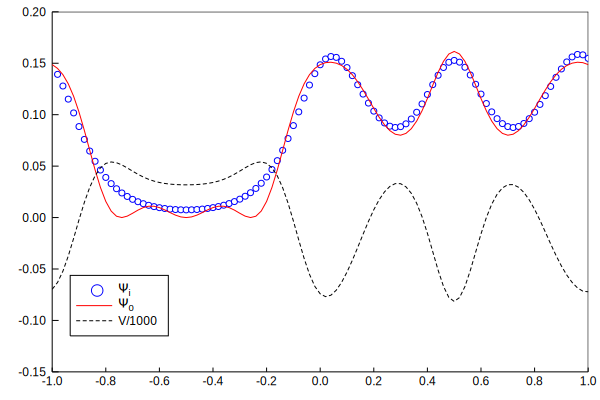

In [13]:
scatter(x, Ψ, label = "\\Psi_i",
        markersize = 3,
        markerstrokecolor = :blue,
        markercolor = :white)

plot!(x, Ψ0, label = "\\Psi_0",
      color = :red)

plot!(x, V / 1000, label = "V/1000",
      linestyle = :dash,
      color = :black)

plot!(xlims = (-1, 1),
      xticks = -1:0.2:1,
      ylims = (-0.15, 0.2),
      yticks = -0.15:0.05:0.2,
      grid = false,
      legend = :bottomleft,
      fmt = :svg,
      framestyle = :box)

That's pretty good, considering it took only a minute on my Thinkpad laptop to optimize 100 dimensional case and the function is not trivial!